# pomegranate / sklearn Naive Bayes comparison

authors: <br>
Nicholas Farn (nicholasfarn@gmail.com) <br>
Jacob Schreiber (jmschreiber91@gmail.com)

<a href="https://github.com/scikit-learn/scikit-learn">sklearn</a> is a very popular machine learning package for Python which implements a wide variety of classical machine learning algorithms. In this notebook we benchmark the Naive Bayes implementations in pomegranate and compare it to the implementation in sklearn.

In [1]:
%pylab inline
import seaborn, time
seaborn.set_style('whitegrid')

from sklearn.naive_bayes import GaussianNB
from pomegranate import *

Populating the interactive namespace from numpy and matplotlib


Lets first define a function which will create a dataset to train on. We want to be able to test a range of datasets, from very small to very large, to see which implementation is faster. We also want a function which will take in the models and evaluate them. Lets define both of those now.

In [2]:
def create_dataset(n_samples, n_dim, n_classes):
    """Create a random dataset with n_samples in each class."""
    
    X = numpy.concatenate([numpy.random.randn(n_samples, n_dim) + i for i in range(n_classes)])
    y = numpy.concatenate([numpy.zeros(n_samples) + i for i in range(n_classes)])
    return X, y

def plot(fit, predict, skl_error, pom_error, sizes, xlabel):
    """Plot the results."""
    
    idx = numpy.arange(fit.shape[1])
    
    plt.figure(figsize=(14, 4))
    plt.plot(fit.mean(axis=0), c='c', label="Fitting")
    plt.plot(predict.mean(axis=0), c='m', label="Prediction")
    plt.plot([0, fit.shape[1]], [1, 1], c='k', label="Baseline")
    
    plt.fill_between(idx, fit.min(axis=0), fit.max(axis=0), color='c', alpha=0.3)
    plt.fill_between(idx, predict.min(axis=0), predict.max(axis=0), color='m', alpha=0.3)
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('pomegranate is x times faster', fontsize=14)
    plt.legend(fontsize=12, loc=4)
    plt.show()
    
    
    plt.figure(figsize=(14, 4))
    plt.plot(1 - skl_error.mean(axis=0), alpha=0.5, c='c', label="sklearn accuracy")
    plt.plot(1 - pom_error.mean(axis=0), alpha=0.5, c='m', label="pomegranate accuracy")
    
    plt.fill_between(idx, 1-skl_error.min(axis=0), 1-skl_error.max(axis=0), color='c', alpha=0.3)
    plt.fill_between(idx, 1-pom_error.min(axis=0), 1-pom_error.max(axis=0), color='m', alpha=0.3)
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=14) 
    plt.show()

Lets look first at single dimension Gaussian datasets. We'll look at how many times faster pomegranate is, which means that values > 1 show pomegranate is faster and < 1 show pomegranate is slower. Lets also look at the accuracy of both algorithms. They should have the same accuracy since they implement the same algorithm.

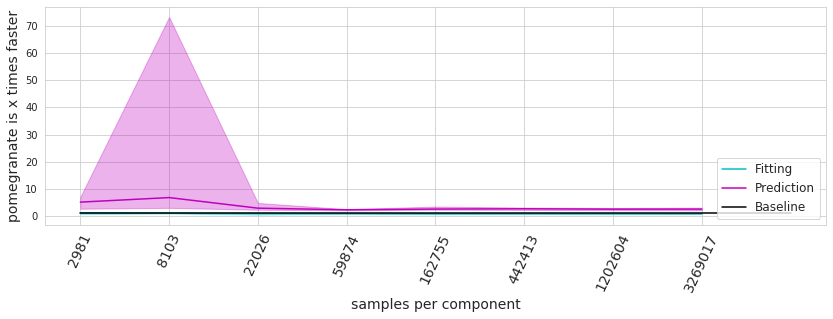

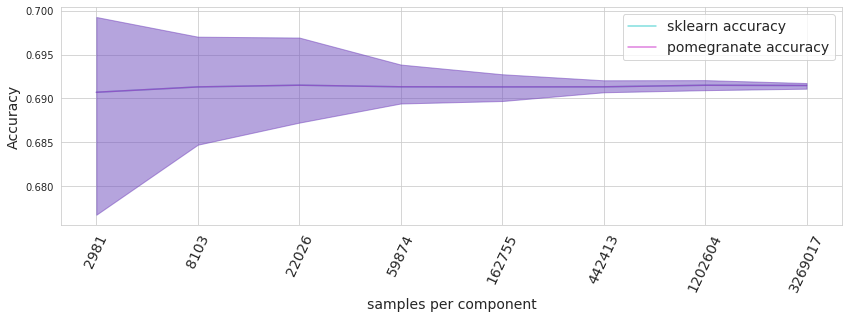

In [3]:
sizes = numpy.around(numpy.exp(numpy.arange(8, 16))).astype('int')
n, m = sizes.shape[0], 20

skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

for i in range(m):
    for j, size in enumerate(sizes):
        X, y = create_dataset(size, 1, 2)

        # bench fit times
        tic = time.time()
        skl = GaussianNB()
        skl.fit(X, y)
        skl_fit[i, j] = time.time() - tic

        tic = time.time()
        pom = NaiveBayes.from_samples(NormalDistribution, X, y)
        pom_fit[i, j] = time.time() - tic

        # bench predict times
        tic = time.time()
        skl_predictions = skl.predict(X)
        skl_predict[i, j] = time.time() - tic

        tic = time.time()
        pom_predictions = pom.predict(X)
        pom_predict[i, j] = time.time() - tic

        # check number wrong
        skl_e = (y != skl_predictions).mean()
        pom_e = (y != pom_predictions).mean()

        skl_error[i, j] = min(skl_e, 1-skl_e)
        pom_error[i, j] = min(pom_e, 1-pom_e)

fit = skl_fit / pom_fit
predict = skl_predict / pom_predict

plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

It looks as if pomegranate is approximately the same speed for training small models but that the prediction time can be a lot faster in pomegranate than in sklearn.

Now let's take a look at how speeds change as we increase the number of classes that need to be predicted rather than phrasing all of the comparisons on binary classification.

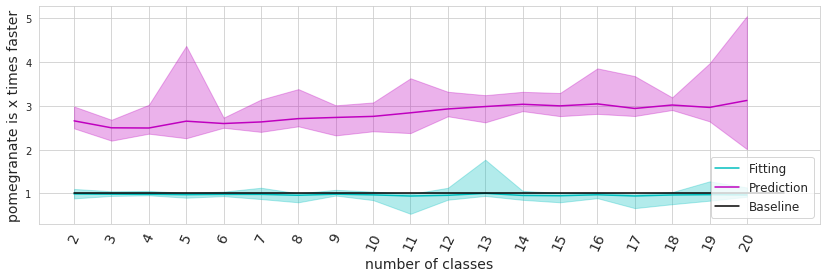

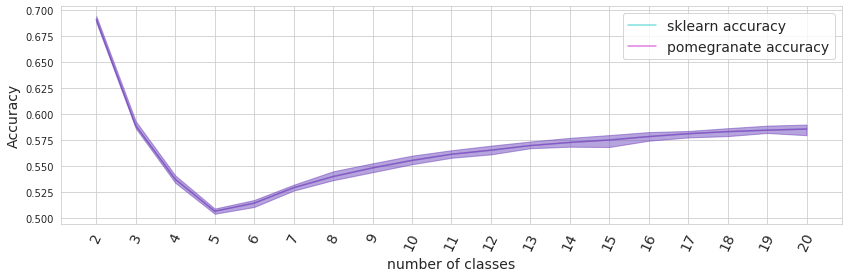

In [4]:
sizes = numpy.arange(2, 21).astype('int')
n, m = sizes.shape[0], 20

skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

for i in range(m):
    for j, size in enumerate(sizes):
        X, y = create_dataset(50000 // size, 1, size)

        # bench fit times
        tic = time.time()
        skl = GaussianNB()
        skl.fit(X, y)
        skl_fit[i, j] = time.time() - tic

        tic = time.time()
        pom = NaiveBayes.from_samples(NormalDistribution, X, y)
        pom_fit[i, j] = time.time() - tic

        # bench predict times
        tic = time.time()
        skl_predictions = skl.predict(X)
        skl_predict[i, j] = time.time() - tic

        tic = time.time()
        pom_predictions = pom.predict(X)
        pom_predict[i, j] = time.time() - tic

        # check number wrong
        skl_e = (y != skl_predictions).mean()
        pom_e = (y != pom_predictions).mean()

        skl_error[i, j] = min(skl_e, 1-skl_e)
        pom_error[i, j] = min(pom_e, 1-pom_e)

fit = skl_fit / pom_fit
predict = skl_predict / pom_predict

plot(fit, predict, skl_error, pom_error, sizes, "number of classes")

It looks like, again, pomegranate is around the same speed as sklearn for fitting models, but that it is consistently much faster to make predictions.

In [5]:
X, y = create_dataset(50000, 1, 2)
skl = GaussianNB()
skl.fit(X, y)

pom = NaiveBayes.from_samples(NormalDistribution, X, y)

%timeit skl.predict(X)
%timeit pom.predict(X)

1.57 ms ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
672 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This does show that pomegranate is faster at making predictions but that both are so fast that potentially it doesn't really matter.

While it's good to start off by looking at naive Bayes' models defined on single features, the more common setting is one where you have many features. Let's look take a look at the relative speeds on larger number of examples when there are 5 features rather than a single one.


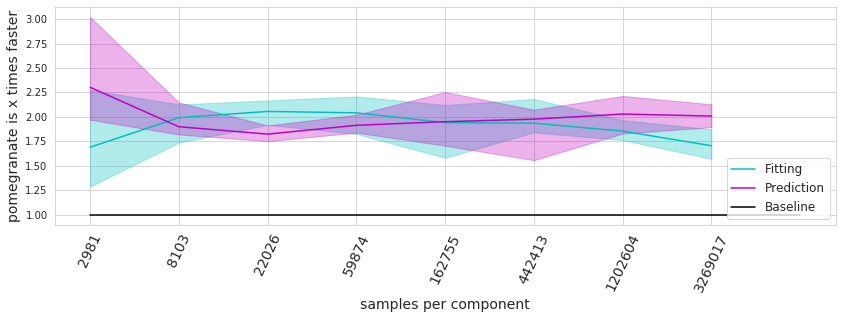

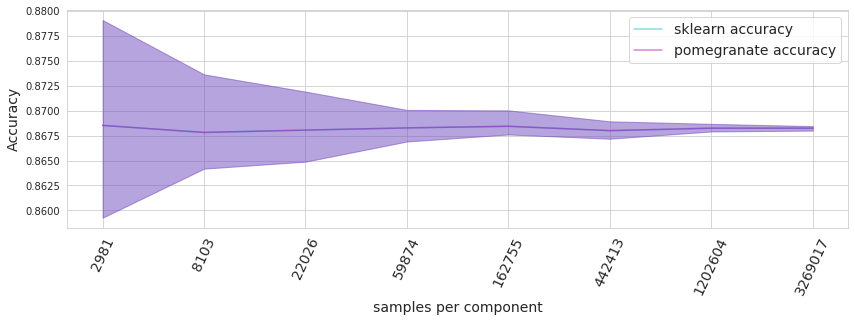

In [6]:
sizes = numpy.around(numpy.exp(numpy.arange(8, 16))).astype('int')
n, m = sizes.shape[0], 20

skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

for i in range(m):
    for j, size in enumerate(sizes):
        X, y = create_dataset(size, 5, 2)

        # bench fit times
        tic = time.time()
        skl = GaussianNB()
        skl.fit(X, y)
        skl_fit[i, j] = time.time() - tic

        tic = time.time()
        pom = NaiveBayes.from_samples(NormalDistribution, X, y)
        pom_fit[i, j] = time.time() - tic

        # bench predict times
        tic = time.time()
        skl_predictions = skl.predict(X)
        skl_predict[i, j] = time.time() - tic

        tic = time.time()
        pom_predictions = pom.predict(X)
        pom_predict[i, j] = time.time() - tic

        # check number wrong
        skl_e = (y != skl_predictions).mean()
        pom_e = (y != pom_predictions).mean()

        skl_error[i, j] = min(skl_e, 1-skl_e)
        pom_error[i, j] = min(pom_e, 1-pom_e)

fit = skl_fit / pom_fit
predict = skl_predict / pom_predict

plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

It looks like pomegranate can be around twice as fast at fitting multivariate Gaussian Naive Bayes models than sklearn when there is more than one feature.

Finally lets show an increasing number of dimensions with a fixed set of 10 classes and 50,000 samples per class.

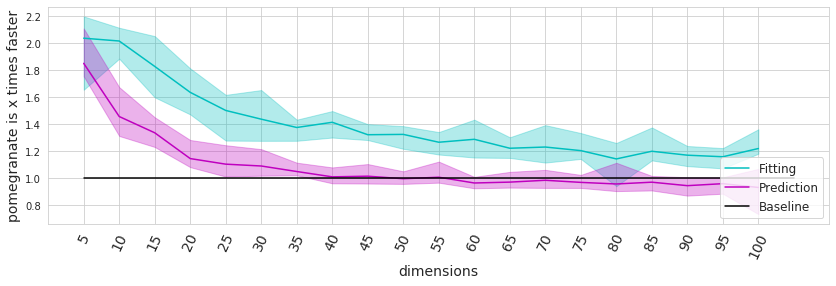

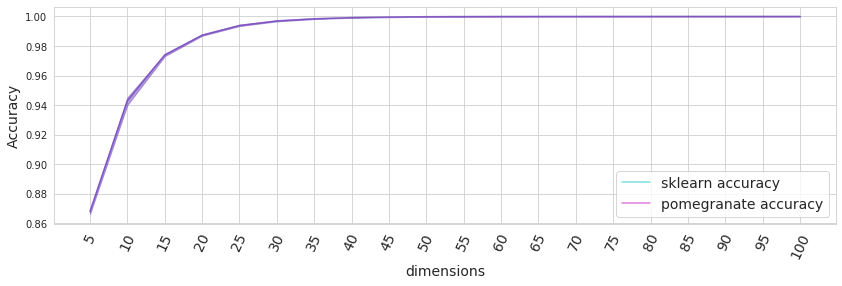

In [7]:
sizes = numpy.arange(5, 101, 5).astype('int')
n, m = sizes.shape[0], 20

skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

for i in range(m):
    for j, size in enumerate(sizes):
        X, y = create_dataset(50000, size, 2)

        # bench fit times
        tic = time.time()
        skl = GaussianNB()
        skl.fit(X, y)
        skl_fit[i, j] = time.time() - tic

        tic = time.time()
        pom = NaiveBayes.from_samples(NormalDistribution, X, y)
        pom_fit[i, j] = time.time() - tic

        # bench predict times
        tic = time.time()
        skl_predictions = skl.predict(X)
        skl_predict[i, j] = time.time() - tic

        tic = time.time()
        pom_predictions = pom.predict(X)
        pom_predict[i, j] = time.time() - tic

        # check number wrong
        skl_e = (y != skl_predictions).mean()
        pom_e = (y != pom_predictions).mean()

        skl_error[i, j] = min(skl_e, 1-skl_e)
        pom_error[i, j] = min(pom_e, 1-pom_e)

fit = skl_fit / pom_fit
predict = skl_predict / pom_predict

plot(fit, predict, skl_error, pom_error, sizes, "dimensions")

Looks like pomegranate is consistently faster than sklearn at fitting the model but conveges to be approximately the same speed at making predictions in the high dimensional setting. Their accuracies remain identical indicating that the two are learning the same model.

## Out of Core Training

Lastly, both pomegranate and sklearn allow for out of core training by fitting on chunks of a dataset. pomegranate does this by calculating summary statistics on the dataset which are enough to allow for exact parameter updates to be done. sklearn implements this using the `model.partial_fit(X, y)` API call, whereas pomegranate uses `model.summarize(X, y)` followed by `model.from_summaries()` to update the internal parameters.  

Lets compare how long each method takes to train on 25 batches of increasing sizes and the accuracy of both methods.

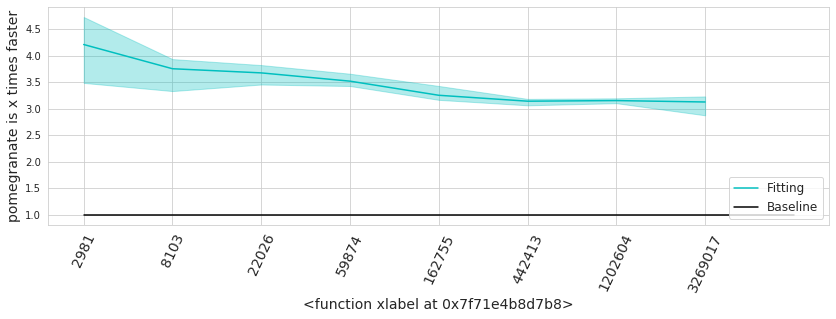

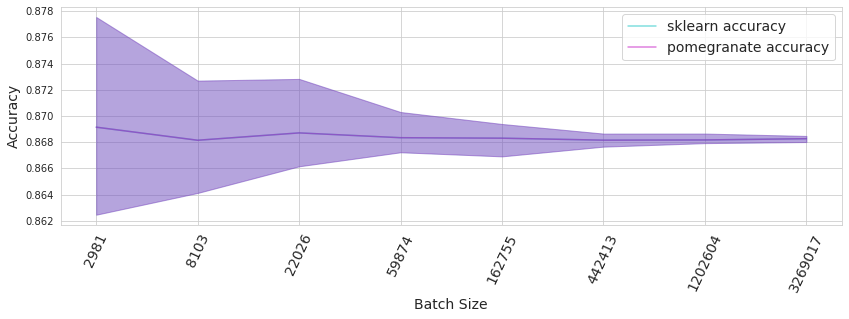

In [8]:
sizes = numpy.around( numpy.exp( numpy.arange(8, 16) ) ).astype('int')
n, m = sizes.shape[0], 20

skl_time, pom_time = numpy.zeros((m, n)), numpy.zeros((m, n))
skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))

for i in range(m):
    for j, size in enumerate(sizes):
        skl = GaussianNB()
        pom = NaiveBayes([IndependentComponentsDistribution([NormalDistribution(0, 1) for i in range(5)]),
                          IndependentComponentsDistribution([NormalDistribution(0, 1) for i in range(5)])])
        
        for l in range(5):
            X, y = create_dataset(size, 5, 2)

            tic = time.time()
            skl.partial_fit(X, y, classes=[0, 1])
            skl_time[i, j] += time.time() - tic

            tic = time.time()
            pom.summarize( X, y )
            pom_time[i, j] += time.time() - tic

        tic = time.time()
        pom.from_summaries()
        pom_time[i, j] += time.time() - tic

        skl_predictions = skl.predict( X )
        pom_predictions = pom.predict( X )

        skl_error[i, j] = ( y != skl_predictions ).mean()
        pom_error[i, j] = ( y != pom_predictions ).mean()

fit = skl_time / pom_time
idx = numpy.arange(fit.shape[1])

plt.figure( figsize=(14, 4))
plt.plot( fit.mean(axis=0), c='c', label="Fitting")
plt.plot( [0, fit.shape[1]], [1, 1], c='k', label="Baseline" )
plt.fill_between( idx, fit.min(axis=0), fit.max(axis=0), color='c', alpha=0.3 )

plt.xticks(idx, sizes, rotation=65, fontsize=14)
plt.xlabel('{}'.format(xlabel), fontsize=14)
plt.ylabel('pomegranate is x times faster', fontsize=14)
plt.legend(fontsize=12, loc=4)
plt.show()

plt.figure( figsize=(14, 4))
plt.plot( 1 - skl_error.mean(axis=0), alpha=0.5, c='c', label="sklearn accuracy" )
plt.plot( 1 - pom_error.mean(axis=0), alpha=0.5, c='m', label="pomegranate accuracy" )

plt.fill_between( idx, 1-skl_error.min(axis=0), 1-skl_error.max(axis=0), color='c', alpha=0.3 )
plt.fill_between( idx, 1-pom_error.min(axis=0), 1-pom_error.max(axis=0), color='m', alpha=0.3 )

plt.xticks( idx, sizes, rotation=65, fontsize=14)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14) 
plt.show()

pomegranate seems to be much faster at doing out-of-core training. The out of core API of calculating sufficient statistics using `summarize` and then updating the model parameters using `from_summaries` extends to all models in pomegranate. 

In this notebook we compared an intersection of the features that pomegranate and sklearn offer. pomegranate allows you to use Naive Bayes with any distribution or model object which has an exposed `log_probability` and `fit` method. This allows you to do things such as compare hidden Markov models to each other, or compare a hidden Markov model to a Markov Chain to see which one models the data better. 

We hope this has been useful to you! If you're interested in using pomegranate, you can get it using `pip install pomegranate` or by checking out the <a href="https://github.com/jmschrei/pomegranate">github repo.</a>